RMSE: 0.396423
179    0.367361
Name: test-rmse-mean, dtype: float64


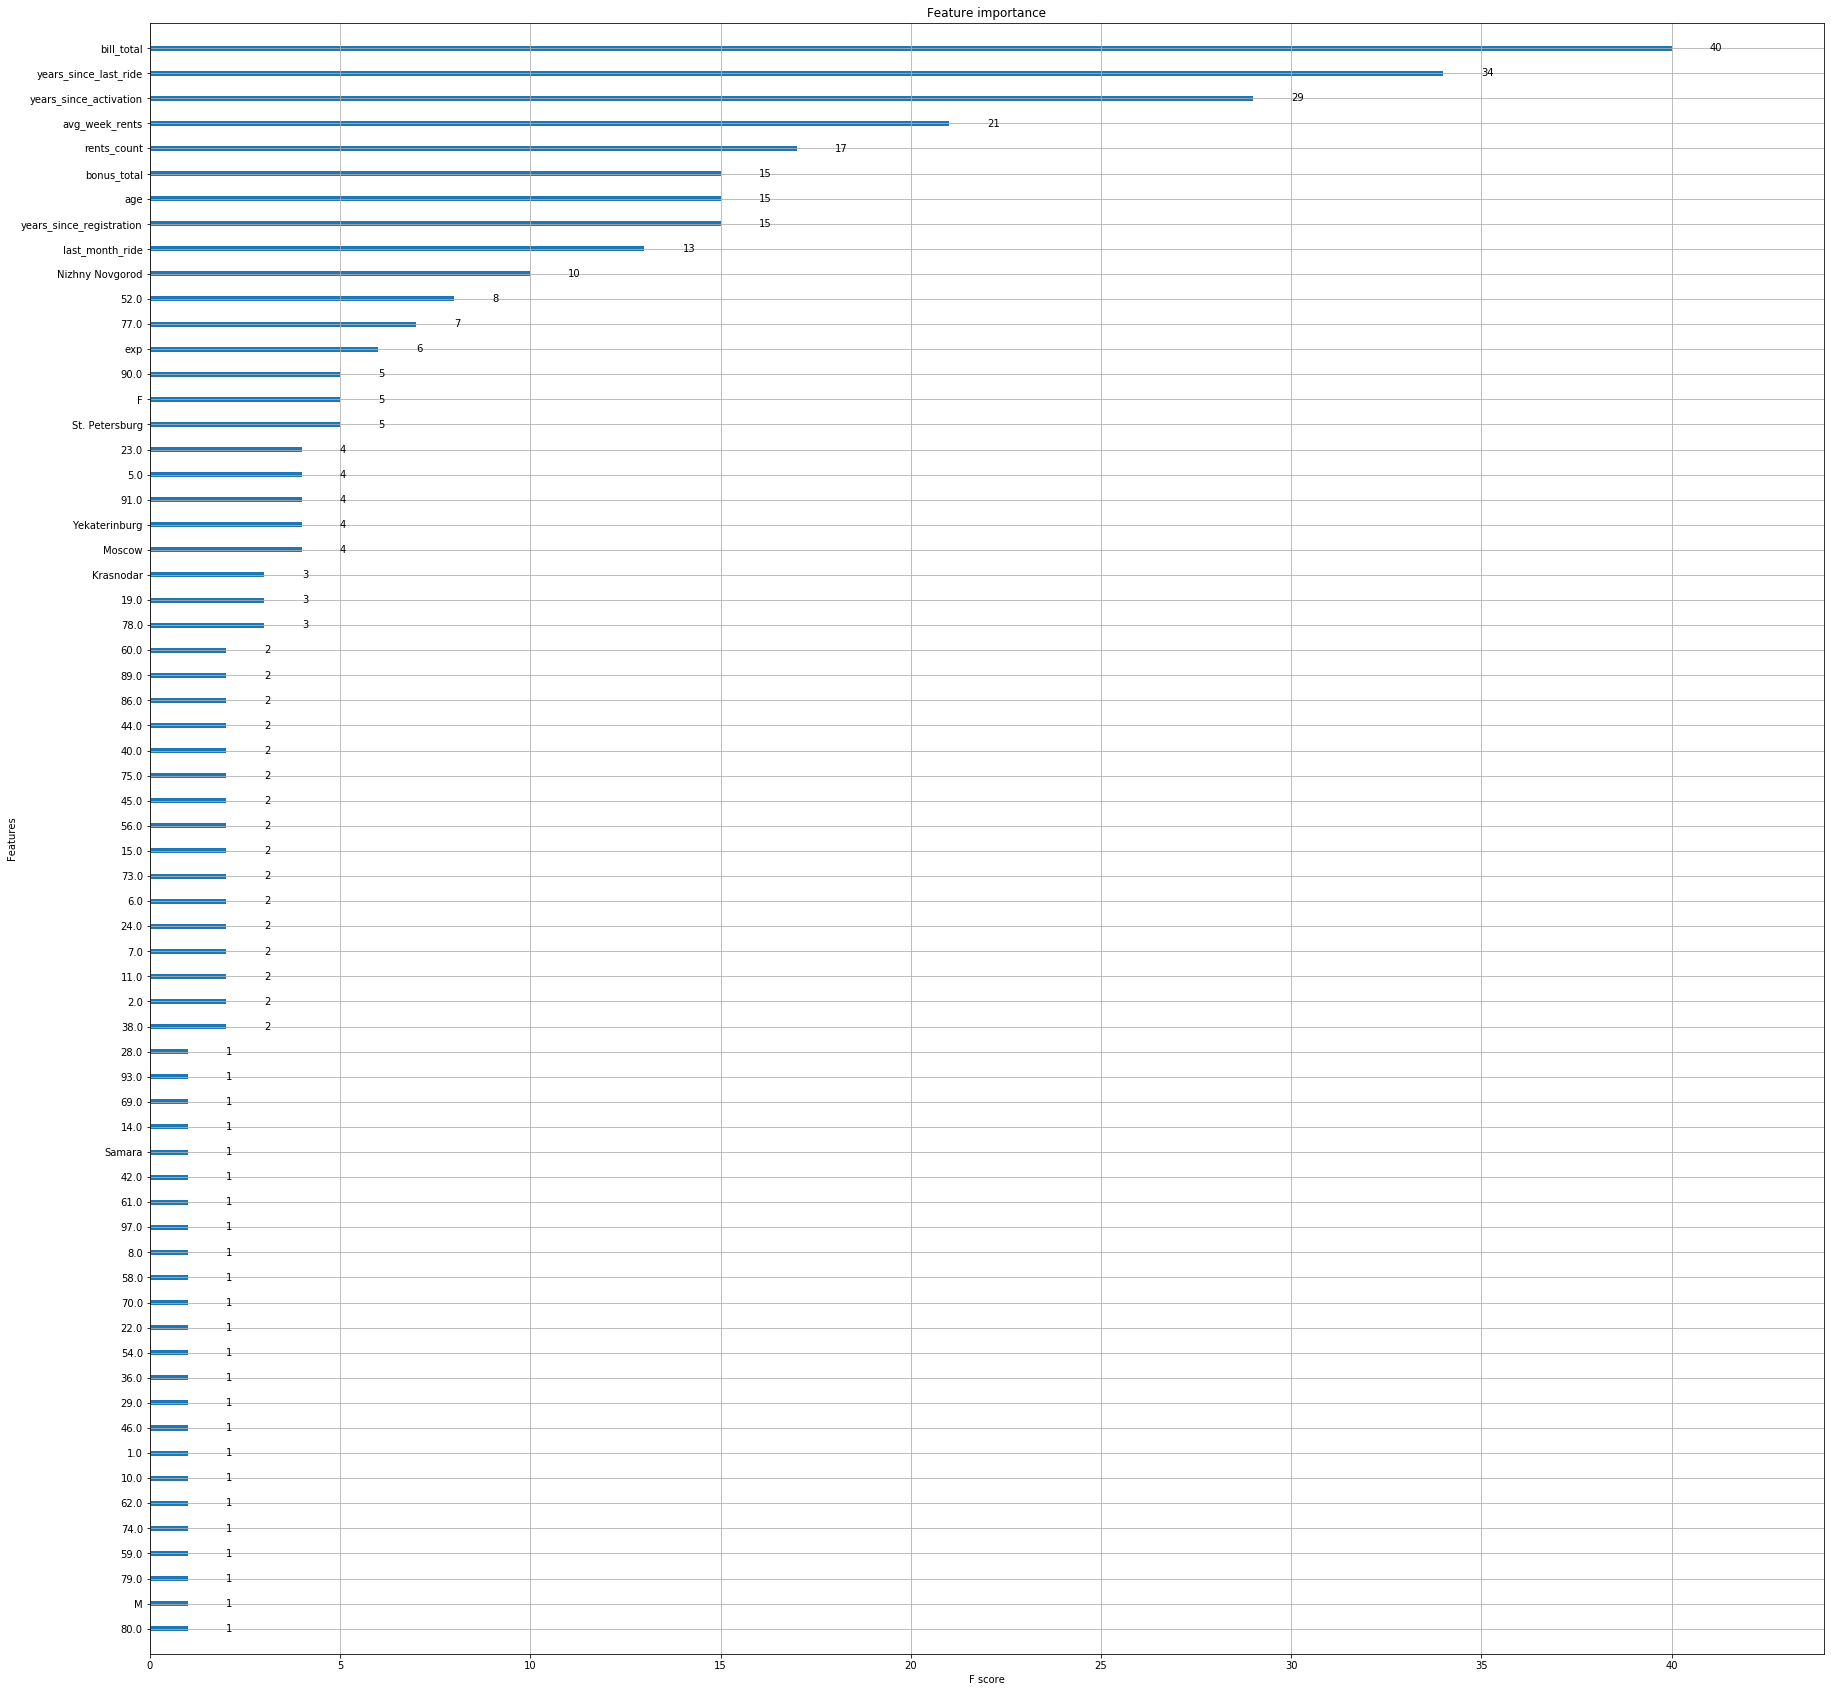

In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/sgulbin/Work/Analysis/Платежеспособность/invoices_payment_analysis_v2.csv')
columns = ['age', 'exp', 'sex', 'years_since_registration', 'years_since_activation',\
         'years_since_last_ride', 'rents_count', 'bill_total', 'bonus_total', 'last_month_ride', 'avg_week_rents',\
           'rent_region','region_code','paid_invoices_%']
df = df[columns]
df = df.dropna(subset=columns, how = 'any')
oh_sex = pd.get_dummies(df['sex'])
oh_rent_region = pd.get_dummies(df['rent_region'])
oh_psp_region_code = pd.get_dummies(df['region_code'])
df = df.drop(['sex', 'rent_region', 'region_code'], axis = 1)
df = df.join(oh_sex)
df = df.join(oh_rent_region)
df = df.join(oh_psp_region_code)
df['target'] = df['paid_invoices_%']
df = df.drop('paid_invoices_%', axis = 1)
df

x, y = df.iloc[:,:-1],df.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=x,label=y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=200,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=20)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

xg_reg